In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import uuid

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler, LabelEncoder

from sklearn.impute import SimpleImputer

from sklearn_pandas import DataFrameMapper

from sklearn.metrics import accuracy_score,r2_score, roc_auc_score
#import dask
#import dask.dataframe as dd


In [ ]:
data_2017=pd.read_csv("data/2017.csv")
data_2018=pd.read_csv("data/2018.csv")
data_2019=pd.read_csv("data/2019.csv")
data_2020=pd.read_csv("data/2020.csv")

useful_columns=data_2020.columns[:30]
data_2016=pd.read_csv("data/2016.csv", encoding = "ISO-8859-1")
data_2016=data_2016[useful_columns]

In [ ]:
data_2015=pd.read_csv("data/2015.csv", encoding = "ISO-8859-1")
data_2015=data_2015[useful_columns]

data_2014=pd.read_csv("data/2014.csv", encoding = "ISO-8859-1")
data_2014=data_2014[useful_columns]

data_2013=pd.read_csv("data/2013.csv", encoding = "ISO-8859-1")
data_2013=data_2013[useful_columns]

data_2012=pd.read_csv("data/2012.csv", encoding = "ISO-8859-1")
data_2012=data_2012[useful_columns]

data_2011=pd.read_csv("data/2011.csv", encoding = "ISO-8859-1")
data_2011=data_2011[useful_columns]

data_2010=pd.read_csv("data/2010.csv", encoding = "ISO-8859-1")
data_2010=data_2010[useful_columns]

In [ ]:
data=data_2020.append(data_2019,sort=True)
data=data.append(data_2018 ,sort=True)
data=data.append(data_2017,sort=True)

data=data[useful_columns]
data=data.append(data_2016)
data=data.append(data_2016,sort=True)
data=data.append(data_2015,sort=True)
data=data.append(data_2014,sort=True)
data=data.append(data_2013,sort=True)
data=data.append(data_2012,sort=True)
data=data.append(data_2011,sort=True)
data=data.append(data_2010,sort=True)

In [ ]:
data.to_csv('data/combined.csv')

In [7]:
data=pd.read_csv('data/combined.csv')

In [ ]:
#data=dd.read_csv('data/combined.csv', blocksize=1.5e6)

In [8]:
# Samples by number of set
data.groupby("Best of")['Best of'].count()/len(data)

Best of
3    0.807921
5    0.192079
Name: Best of, dtype: float64

In [9]:
print("% of games with only top 100 players: ",len(data[(data.WRank<=100) & (data.LRank<=100)])/len(data))

% of games with only top 100 players:  0.6578956431892543


In [10]:
# Removing NaNs
data=(data[(data.WRank>=1) & (data.LRank>=1)])

In [11]:
data['rank_diff']=data['LRank'] - data['WRank']
#data.map_partitions

In [12]:
data['outcome']=data[['WRank','LRank']].apply(lambda x: 1 if x.WRank<x.LRank else 0, axis=1)

In [13]:
#% of time the higher ranked player wins
data.groupby("outcome")['outcome'].count()/len(data)

outcome
0    0.340124
1    0.659876
Name: outcome, dtype: float64

In [14]:
def player_one(Winner,WRank,Loser,LRank):
        if WRank<LRank:
            return Winner
        else:
            return Loser

def player_two(Winner,WRank,Loser,LRank):
        if WRank<LRank:
            return Loser
        else:
            return Winner
        
def player_one_rank(Winner,WRank,Loser,LRank):
        if WRank<LRank:
            return WRank
        else:
            return LRank

def player_two_rank(Winner,WRank,Loser,LRank):
        if WRank<LRank:
            return LRank
        else:
            return WRank        

In [15]:
%%time 
data['player_one']=data.apply(lambda row: player_one(row['Winner'],row['WRank'], row['Loser'], row['LRank']), axis=1)
data['player_two']=data.apply(lambda row: player_two(row['Winner'],row['WRank'], row['Loser'], row['LRank']), axis=1)

CPU times: user 2.27 s, sys: 43.4 ms, total: 2.32 s
Wall time: 2.32 s


In [16]:
data['player_one_rank']=data.apply(lambda row: player_one_rank(row['Winner'],row['WRank'], row['Loser'], row['LRank']), axis=1)
data['player_two_rank']=data.apply(lambda row: player_two_rank(row['Winner'],row['WRank'], row['Loser'], row['LRank']), axis=1)

In [17]:
data['uuid'] = [uuid.uuid4() for _ in range(len(data.index))]

In [18]:
data=data.set_index(data['uuid'])

In [19]:
data.Date=(pd.to_datetime(data.Date))

In [20]:
%%time
def cal_player_stats(name,date,uuid):
    three=0.0
    five=0.0
    clay=0.0
    hard=0.0
    grass=0.0
    try:
        temp=data[(data.player_one==name) | (data.player_two==name)]
        cutoff_date=date-pd.Timedelta(days=366)
        temp=temp[temp.Date>cutoff_date].iloc[1:,:]
        if (len(temp)==0):
            return 
        else:
            
            d={}
            for i in temp['Best of'].unique():
                d[str(i)]=(len(temp[(temp['Best of']==i) & (temp.outcome==1) & (temp.player_one==name)]))/(len(temp[temp['Best of']==i]))
            for i in temp.Surface.unique():
                d[i]=(len(temp[(temp.Surface==i) & (temp.outcome==1) & (temp.player_one==name)]))/(len(temp[temp.Surface==i]))    
            if '3' in d:
                three = (d['3'])
            if '5' in d:
                five = (d['5'])
            if 'Grass' in d:
                grass = (d['Grass'])
            if 'Hard' in d:
                hard = (d['Hard'])       
            if 'Clay' in d:
                clay = (d['Clay'])        
            return pd.Series([uuid,name,date,cutoff_date,np.sum(temp.outcome==1)/len(temp),len(temp), clay, grass, hard, three, five])
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print(exc_tb.tb_lineno, name, date)


x=data[(data.Date>='2011-01-01')].apply(lambda row: cal_player_stats(row['player_one'],row['Date'], row['uuid']), axis=1)

CPU times: user 9min 17s, sys: 3.6 s, total: 9min 21s
Wall time: 9min 37s


In [21]:
t=x

In [22]:
x=pd.DataFrame(x)
x.columns=['uuid','one_name','one_date','one_cutoff_date','one_win_rate_year','one_games_played_year'
           ,'one_clay_year','one_grass_year','one_hard_year','one_three_year','one_five_year']
x=x.set_index('uuid')

In [23]:
new_data=data.merge(x,how='left', left_index=True, right_index=True)

In [24]:
%%time
x=data[(data.Date>='2011-01-01')].apply(lambda row: cal_player_stats(row['player_two'],row['Date'], row['uuid']), axis=1)

CPU times: user 8min 56s, sys: 3.62 s, total: 8min 59s
Wall time: 9min 11s


In [25]:
x=pd.DataFrame(x)
x.columns=['uuid','two_name','two_date','two_cutoff_date','two_win_rate_year','two_games_played_year'
           ,'two_clay_year','two_grass_year','two_hard_year','two_three_year','two_five_year']
x=x.set_index('uuid')

In [26]:
new_data=new_data.merge(x,how='left', left_index=True, right_index=True)

In [27]:
new_data.columns

Index(['Unnamed: 0', 'ATP', 'B365L', 'B365W', 'Best of', 'Comment', 'Court',
       'Date', 'L1', 'L2', 'L3', 'L4', 'L5', 'LPts', 'LRank', 'Location',
       'Loser', 'Lsets', 'Round', 'Series', 'Surface', 'Tournament', 'W1',
       'W2', 'W3', 'W4', 'W5', 'WPts', 'WRank', 'Winner', 'Wsets', 'rank_diff',
       'outcome', 'player_one', 'player_two', 'player_one_rank',
       'player_two_rank', 'uuid', 'one_name', 'one_date', 'one_cutoff_date',
       'one_win_rate_year', 'one_games_played_year', 'one_clay_year',
       'one_grass_year', 'one_hard_year', 'one_three_year', 'one_five_year',
       'two_name', 'two_date', 'two_cutoff_date', 'two_win_rate_year',
       'two_games_played_year', 'two_clay_year', 'two_grass_year',
       'two_hard_year', 'two_three_year', 'two_five_year'],
      dtype='object')

In [28]:
top_tournaments=[
'Australian Open',
'US Open',
'Wimbledon',
'French Open',
]
new_data['major']=new_data.Tournament.apply(lambda x: 1 if x in top_tournaments else 0)

In [29]:
t=new_data

In [30]:
totalgames=new_data.loc[:,['W1', 'W2', 'W3', 'W4', 'W5','L1', 'L2', 'L3', 'L4', 'L5']]

In [31]:
new_data['total_games']=totalgames.fillna(0).sum(axis=1)

In [32]:
new_data['player_one_total_games']=totalgames[['W1', 'W2', 'W3', 'W4', 'W5']].fillna(0).sum(axis=1)

In [33]:
new_data['player_two_total_games']=totalgames[['L1', 'L2', 'L3', 'L4', 'L5']].fillna(0).sum(axis=1)

In [34]:
new_data['total_sets']=new_data['Wsets']+new_data['Lsets']

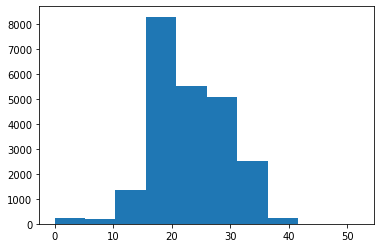

In [35]:
plt.hist(new_data[new_data['Best of']==3].total_games);

In [36]:
def calc_rate(x,y):
    if (x+y)>0:
      return x/(x+y)
    return 0.0  

def onevtwo(player_one_name,player_two_name,cut_off_date,uuid):
    three=0.0
    five=0.0
    clay=0.0
    hard=0.0
    grass=0.0
    win_rate=0.0
    total=0.0
    d={}
    try:
        temp=data[data.Date>cut_off_date].iloc[1:,:]
        wins=temp[(temp.Winner==player_one_name) & (temp.Loser==player_two_name)]
        losses=temp[(temp.Loser==player_one_name) & (temp.Winner==player_two_name)]
        #win_rate=calc_rate(len(wins),len(losses))
        total=len(wins)+len(losses)
        if total >0:
            win_rate= len(wins)/total
        #return 0.0
        
        for i in temp['Best of'].unique():
            d[str(i)]=calc_rate(len(wins[wins['Best of']==i]),len(losses[losses['Best of']==i]))
                
        for i in temp.Surface.unique():
                d[i]=calc_rate(len(wins[wins.Surface==i]),len(losses[losses.Surface==i]))
        if '3' in d:
                three = (d['3'])
        if '5' in d:
                five = (d['5'])
        if 'Grass' in d:
                grass = (d['Grass'])
        if 'Hard' in d:
                hard = (d['Hard'])       
        if 'Clay' in d:
                clay = (d['Clay'])        
        return pd.Series([uuid,player_one_name,cut_off_date,win_rate,total, clay, grass, hard, three, five])
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print(exc_tb.tb_lineno, player_one_name, cut_off_date)


In [37]:
%%time
x=new_data[(new_data.Date>='2011-01-01')].apply(lambda row: onevtwo(row['Loser'],row['Winner'],row['two_cutoff_date'], row['uuid']), axis=1)

CPU times: user 8min 19s, sys: 22.7 s, total: 8min 42s
Wall time: 8min 47s


In [38]:
x=pd.DataFrame(x)
x.columns=['uuid','player_two_name_vv','two_cutoff_date_vv','two_win_rate_vv','two_games_played_vv'
           ,'two_clay_vv','two_grass_vv','two_hard_vv','two_three_vv','two_five_vv']
x=x.set_index('uuid')

In [39]:
new_data=new_data.merge(x,how='left', left_index=True, right_index=True)

In [40]:
%%time
x=new_data[(new_data.Date>='2011-01-01')].apply(lambda row: onevtwo(row['Winner'],row['Loser'],row['one_cutoff_date'], row['uuid']), axis=1)

CPU times: user 8min 36s, sys: 23.9 s, total: 9min
Wall time: 9min 17s


In [41]:
x=pd.DataFrame(x)
x.columns=['uuid','player_one_name_vv','one_cutoff_date_vv','one_win_rate_vv','one_games_played_vv'
           ,'one_clay_vv','one_grass_vv','one_hard_vv','one_three_vv','one_five_vv']
x=x.set_index('uuid')

In [42]:
new_data=new_data.merge(x,how='left', left_index=True, right_index=True)

In [43]:
new_data['pts_diff']=new_data['WPts'] - new_data['LPts']

In [44]:
def player_one_pts(WRank,WPts,LRank,LPts):
        if WRank<LRank:
            return WPts
        else:
            return LPts

def player_two_pts(WRank,WPts,LRank,LPts):
        if WRank<LRank:
            return LPts
        else:
            return WPts
        
def player_one_sets(WRank,Wsets,LRank,Lsets):
        if WRank<LRank:
            return Wsets
        else:
            return Lsets
        
def player_two_sets(WRank,Wsets,LRank,Lsets):
        if WRank<LRank:
            return Lsets
        else:
            return Wsets        

In [45]:
%%time 
new_data['player_one_pts']=new_data.apply(lambda row: player_one_pts(row['WRank'],row['WPts'], row['LRank'], row['LPts']), axis=1)
new_data['player_two_pts']=new_data.apply(lambda row: player_two_pts(row['WRank'],row['WPts'], row['LRank'], row['LPts']), axis=1)

CPU times: user 4.43 s, sys: 319 ms, total: 4.75 s
Wall time: 4.73 s


In [46]:
%%time 
new_data['player_one_sets']=new_data.apply(lambda row: player_one_sets(row['WRank'],row['Wsets'], row['LRank'], row['Lsets']), axis=1)
new_data['player_two_sets']=new_data.apply(lambda row: player_two_sets(row['WRank'],row['Wsets'], row['LRank'], row['Lsets']), axis=1)

CPU times: user 4.38 s, sys: 147 ms, total: 4.53 s
Wall time: 4.27 s


In [47]:
new_data.head()

,Unnamed: 0,ATP,B365L,B365W,Best of,Comment,Court,Date,L1,L2,...,one_clay_vv,one_grass_vv,one_hard_vv,one_three_vv,one_five_vv,pts_diff,player_one_pts,player_two_pts,player_one_sets,player_two_sets
uuid,,,,,,,,,,,,,,,,,,,,,
000569ca-bcdb-4266-98a0-b409cb8932ff,383,11,5.00,1.16,3,Completed,Indoor,2016-02-09,3.0,4.0,...,0.0,0.0,1.0,1.0,0.0,301.0,414.0,113.0,2.0,0.0
00056f39-ba9b-4807-ac20-cbbcf9e2c304,1887,45,1.36,3.00,3,Retired,Outdoor,2010-08-04,5.0,2.0,...,NaN,NaN,NaN,NaN,NaN,-610.0,1385.0,775.0,0.0,1.0
000a7190-03aa-44b3-b631-e85d00f265ea,1537,39,3.00,1.36,5,Completed,Outdoor,2015-06-29,3.0,7.0,...,0.0,1.0,1.0,1.0,1.0,347.0,895.0,548.0,3.0,2.0
000c3ad6-ac2d-4ca8-abe9-853099f8a568,597,18,19.00,1.02,3,Completed,Outdoor,2012-02-28,3.0,6.0,...,1.0,0.0,1.0,1.0,1.0,6663.0,7150.0,487.0,2.0,1.0
0014c43e-cdee-41e7-a5f8-60a15a6f9cc2,2510,63,9.00,1.07,3,Completed,Indoor,2016-10-25,7.0,1.0,...,0.0,0.0,1.0,1.0,0.0,5311.0,5820.0,509.0,2.0,1.0


In [48]:
new_data.to_csv('data/final_2.csv', header=True)